# Notebook 04 - Preprocessing

## Objective
The purpose of this notebook is to prepare the cleaned Silver dataset for machine learning modeling by applying systematic preprocessing steps.
This stage focuses on transforming the data so that all features are consistent, meaningful, and optimized for training robust intrusion-detection models.

In this notebook, we will:

- Load the consolidated Silver dataset
- Remove irrelevant or non-discriminative features identified during EDA
- Eliminate redundant variables based on multicollinearity analysis
- Apply normalization or standardization to numerical features
- Encode categorical variables (e.g., attack names)
- Handle class imbalance using appropriate resampling techniques
- Apply t-SNE and LDA to visually inspect whether the selected features allow separation of the attack classes
- Prepare the final feature matrix (X) and target vector (y)
- Export the fully preprocessed dataset to the Gold layer for downstream modeling

This notebook does not perform any model training.

Its goal is to produce a clean, compact, and ready-to-train dataset that preserves all relevant attack characteristics while minimizing noise, redundancy, and bias.

# Libraries

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle

# Load Silver Data

In [2]:
silver_path = Path("../data/silver/data_merge_and_cleaned.csv")

# Check if file exists
if not silver_path.exists():
    raise FileNotFoundError(f"File not found: {silver_path}")
else:
    print(f"Loading dataset from: {silver_path}")

chunk_iter = pd.read_csv("../data/silver/data_merge_and_cleaned.csv", chunksize=100000)
df = pd.concat(chunk_iter, ignore_index=True)
print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]:,} columns\n")

# Show first 5 rows
df.head()

Loading dataset from: ..\data\silver\data_merge_and_cleaned.csv

Dataset loaded successfully!
Shape: 3,276,133 rows × 86 columns



,Flow ID,Src IP,Src Port,Dst IP,Dst Port,Protocol,Timestamp,Flow Duration,Total Fwd Packet,Total Bwd packets,...,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Attack Name,Label,source_file
0,34.173.20.6-192.168.137.234-443-58644-6,34.173.20.6,443.0,192.168.137.234,58644.0,6.0,2023-09-14 09:24:26,14746364.0,6.0,0.0,...,0.0,0.0,0.0,14681116.0,0.000000,14681116.0,14681116.0,Benign Traffic,0,Benign Traffic.csv
1,34.173.20.6-192.168.137.234-443-58646-6,34.173.20.6,443.0,192.168.137.234,58646.0,6.0,2023-09-14 09:24:41,60102110.0,18.0,0.0,...,0.0,219123.0,219123.0,14957706.0,190543.248665,15061923.0,14672051.0,Benign Traffic,0,Benign Traffic.csv
2,52.40.210.103-192.168.137.40-18665-60378-6,52.40.210.103,18665.0,192.168.137.40,60378.0,6.0,2023-09-14 09:24:14,90106769.0,9.0,0.0,...,0.0,582529.0,582529.0,29841412.0,319090.538141,30049066.0,29473997.0,Benign Traffic,0,Benign Traffic.csv
3,10.0.0.3-10.0.0.254-44505-1883-6,10.0.0.3,44505.0,10.0.0.254,1883.0,6.0,2023-09-14 09:24:15,119998980.0,123.0,123.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign Traffic,0,Benign Traffic.csv
4,10.0.0.7-10.0.0.254-45727-1883-6,10.0.0.7,45727.0,10.0.0.254,1883.0,6.0,2023-09-14 09:24:15,119998539.0,123.0,123.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,Benign Traffic,0,Benign Traffic.csv


# Delete irrelevant features (statistic tests)

In [3]:
print("Initial shape:", df.shape)

irrelevant_features = [
    "Protocol",
    "Bwd PSH Flags",
    "Bwd URG Flags",
    "Fwd Bytes/Bulk Avg",
    "Fwd Packet/Bulk Avg",
    "Fwd Bulk Rate Avg",
    "PSH Flag Count",
    "FIN Flag Count",
    "ECE Flag Count",
    "CWR Flag Count"
]

cols_to_drop = [col for col in irrelevant_features if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True)

print("Removed irrelevant features:", len(cols_to_drop))
print("Dropped columns:", cols_to_drop)
print("New shape after removal:", df.shape)


Initial shape: (3276133, 86)
Removed irrelevant features: 10
Dropped columns: ['Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'PSH Flag Count', 'FIN Flag Count', 'ECE Flag Count', 'CWR Flag Count']
New shape after removal: (3276133, 76)


# Delete multicol features

In [4]:
print("Initial shape (before multicollinearity removal):", df.shape)

redundant_features = [

    # Backward Length & IAT
    "Bwd Packet Length Max",
    "Bwd Packet Length Std",
    "Bwd Segment Size Avg",
    "Total Length of Bwd Packet",
    "Bwd IAT Total",
    "Bwd IAT Max",
    "Bwd IAT Std",

    # Forward Length & IAT
    "Fwd Packet Length Max",
    "Fwd Packet Length Std",
    "Fwd Segment Size Avg",
    "Total Length of Fwd Packet",
    "Fwd IAT Total",
    "Fwd IAT Max",
    "Fwd IAT Std",

    # Packet Length Group
    "Packet Length Max",
    "Packet Length Std",
    "Packet Length Variance",
    "Average Packet Size",

    # Active/Idle
    "Idle Max",
    "Idle Min",
    "Idle Std",
    "Active Max",
    "Active Min",
    "Active Std",

    # Other correlated variables
    "Fwd Act Data Pkts",
    "Fwd Header Length",
    "Bwd Header Length",
    "Flow IAT Mean",
    "Flow IAT Std",
    "Flow IAT Max",
    "Flow IAT Min",
    "Flow Packets/s",
    "Bwd Packets/s",
    "Fwd Packets/s",
    "Flow Bytes/s",
    "Bwd IAT Min",
    "Fwd IAT Min",
]

cols_to_drop = [c for c in redundant_features if c in df.columns]

df.drop(columns=cols_to_drop, inplace=True)

print("Multicollinearity redundant features removed:", len(cols_to_drop))
print("Dropped columns:", cols_to_drop)
print("New shape after multicollinearity cleaning:", df.shape)


Initial shape (before multicollinearity removal): (3276133, 76)
Multicollinearity redundant features removed: 37
Dropped columns: ['Bwd Packet Length Max', 'Bwd Packet Length Std', 'Bwd Segment Size Avg', 'Total Length of Bwd Packet', 'Bwd IAT Total', 'Bwd IAT Max', 'Bwd IAT Std', 'Fwd Packet Length Max', 'Fwd Packet Length Std', 'Fwd Segment Size Avg', 'Total Length of Fwd Packet', 'Fwd IAT Total', 'Fwd IAT Max', 'Fwd IAT Std', 'Packet Length Max', 'Packet Length Std', 'Packet Length Variance', 'Average Packet Size', 'Idle Max', 'Idle Min', 'Idle Std', 'Active Max', 'Active Min', 'Active Std', 'Fwd Act Data Pkts', 'Fwd Header Length', 'Bwd Header Length', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Flow Packets/s', 'Bwd Packets/s', 'Fwd Packets/s', 'Flow Bytes/s', 'Bwd IAT Min', 'Fwd IAT Min']
New shape after multicollinearity cleaning: (3276133, 39)


# Delete ID's and other features that only add noise and bias for model

In [5]:
print("Initial shape:", df.shape)


id_columns = [
    "Flow ID",
    "Timestamp",
    "source_file",
    "Src IP",
]

cols_to_drop = [col for col in id_columns if col in df.columns]

df.drop(columns=cols_to_drop, inplace=True)

print("Removed identifier columns:", len(cols_to_drop))
print("Dropped:", cols_to_drop)
print("New shape after identifier removal:", df.shape)

Initial shape: (3276133, 39)
Removed identifier columns: 4
Dropped: ['Flow ID', 'Timestamp', 'source_file', 'Src IP']
New shape after identifier removal: (3276133, 35)


# Summary of features

In [8]:
print("Remaining columns:", df.columns.tolist())

Remaining columns: ['Src Port', 'Dst IP', 'Dst Port', 'Flow Duration', 'Total Fwd Packet', 'Total Bwd packets', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Bwd Packet Length Min', 'Bwd Packet Length Mean', 'Fwd IAT Mean', 'Bwd IAT Mean', 'Fwd PSH Flags', 'Fwd URG Flags', 'Packet Length Min', 'Packet Length Mean', 'SYN Flag Count', 'RST Flag Count', 'ACK Flag Count', 'URG Flag Count', 'Down/Up Ratio', 'Bwd Bytes/Bulk Avg', 'Bwd Packet/Bulk Avg', 'Bwd Bulk Rate Avg', 'Subflow Fwd Packets', 'Subflow Fwd Bytes', 'Subflow Bwd Packets', 'Subflow Bwd Bytes', 'FWD Init Win Bytes', 'Bwd Init Win Bytes', 'Fwd Seg Size Min', 'Active Mean', 'Idle Mean', 'Attack Name', 'Label']


| Feature                    | Reason to Keep                                                                                                                 |
| -------------------------- | ------------------------------------------------------------------------------------------------------------------------------ |
| **Src Port**               | Captures traffic patterns, ephemeral port behavior, DoS/scan signatures; generalizes well across networks.                     |
| **Dst IP**                 | Represents IoT services being targeted; useful for distinguishing attacks vs benign traffic without leaking attacker identity. |
| **Dst Port**               | Strong discriminator of protocol type and service targeted; essential in network intrusion tasks.                              |
| **Flow Duration**          | High predictive power for DoS and slow-rate attacks; fundamental temporal descriptor.                                          |
| **Total Fwd Packet**       | Measures client → server intensity; key for flooding and MQTT-based attacks.                                                   |
| **Total Bwd packets**      | Measures server → client response behavior; relevant for DoS, scans, and anomalies.                                            |
| **Fwd Packet Length Min**  | Low-level packet signature; different for ICMP, MQTT, TCP, UDP attacks.                                                        |
| **Fwd Packet Length Mean** | Representative dimension kept from highly-correlated group; describes forward packet size behavior.                            |
| **Bwd Packet Length Min**  | Helps differentiate attacks with short backward responses (e.g., DoS vs benign).                                               |
| **Bwd Packet Length Mean** | Kept as the representative feature for backward size pattern analysis.                                                         |
| **Fwd IAT Mean**           | Key temporal descriptor; useful for identifying floods, scans, and IoT burst patterns.                                         |
| **Bwd IAT Mean**           | Captures timing irregularities in server responses; strong for MQTT DoS and ICMP floods.                                       |
| **Fwd PSH Flags**          | One of the few TCP flags with real discriminative power in this dataset.                                                       |
| **Fwd URG Flags**          | Low frequency but relevant for specific anomalies and malformed packet behavior.                                               |
| **Packet Length Min**      | Low-level signature supporting identification of traffic families.                                                             |
| **Packet Length Mean**     | Representative feature from the packet-length group (max, variance, std eliminated).                                           |
| **SYN Flag Count**         | Strong signal for TCP SYN floods and recon scans; highly discriminative.                                                       |
| **RST Flag Count**         | Very high MI for TCP-based DoS; resets spike during disruption attacks.                                                        |
| **ACK Flag Count**         | Captures handshake behavior; highly informative for TCP attacks.                                                               |
| **URG Flag Count**         | Rare flag; helps identify malformed or anomalous flows.                                                                        |
| **Down/Up Ratio**          | Important behavioral ratio; strong indicator of scanning and asymmetric flows.                                                 |
| **Bwd Bytes/Bulk Avg**     | Representative statistical feature retained from bulk-related group.                                                           |
| **Bwd Packet/Bulk Avg**    | Helps identify large aggregated server responses (MQTT attacks).                                                               |
| **Bwd Bulk Rate Avg**      | Complementary bulk communication rate descriptor.                                                                              |
| **Subflow Fwd Packets**    | Useful for understanding multi-flow behavior in MQTT and scan attacks.                                                         |
| **Subflow Fwd Bytes**      | Represents forward aggregated traffic; informative for floods.                                                                 |
| **Subflow Bwd Packets**    | Captures server-side multi-flow interactions.                                                                                  |
| **Subflow Bwd Bytes**      | Complements backward subflow behavior tracking.                                                                                |
| **FWD Init Win Bytes**     | TCP window size anomalies are common in DoS and malformed traffic.                                                             |
| **Bwd Init Win Bytes**     | Supports TCP state analysis on server responses.                                                                               |
| **Fwd Seg Size Min**       | Maintains diversity in forward-segment metrics; non-redundant.                                                                 |
| **Active Mean**            | Representative feature for activity cycle; others (max/min/std) removed.                                                       |
| **Idle Mean**              | Representative idle-time descriptor; others removed.                                                                           |
| **Attack Name**            | Multiclass label — preserved for supervised learning.                                                                          |
| **Label**                  | Binary label — preserved for binary classification or hierarchical models.                                                     |


# Standardization to numerical features


In [6]:
# Select numerical columns (excluding labels)
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_features = [c for c in numeric_features if c not in ["Label", "Attack Name"]]

# Initialize scaler
scaler = StandardScaler()

# Fit the scaler on the numerical data
df_scaled = df.copy()
df_scaled[numeric_features] = scaler.fit_transform(df[numeric_features])

print("Standardization complete. All numeric features are now Z-score scaled.")
print(f"Total standardized features: {len(numeric_features)}")

Standardization complete. All numeric features are now Z-score scaled.
Total standardized features: 32


# Label encoder to Attack Name and DTS_IP

In [7]:
# Initialize encoder
le = LabelEncoder()
le_ip = LabelEncoder()

# Fit + transform
df_scaled["Attack_Encoded"] = le.fit_transform(df_scaled["Attack Name"])
df_scaled["DstIP_Encoded"] = le_ip.fit_transform(df_scaled["Dst IP"])
print("Attack Name and Dst IP encoded successfully.")
print(f"Number of attack classes: {len(le.classes_)}")
print(F"Number of Dst IPs encoded: {len(df_scaled['DstIP_Encoded'].unique())}")

# show mapping
attack_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
DTSIP_mapping = dict(zip(le_ip.classes_, le_ip.transform(le_ip.classes_)))
print("\nAttack Encoding Map:")
for k, v in attack_mapping.items():
    print(f"{k} --> {v}")
print("\nDst IP Encoding Map:")
for k, v in DTSIP_mapping.items():
    print(f"{k} --> {v}")


Attack Name and Dst IP encoded successfully.
Number of attack classes: 15
Number of Dst IPs encoded: 354

Attack Encoding Map:
Benign Traffic --> 0
DDoS ICMP Flood --> 1
DDoS UDP Flood --> 2
DoS ICMP Flood --> 3
DoS TCP Flood --> 4
DoS UDP Flood --> 5
MITM ARP Spoofing --> 6
MQTT DDoS Publish Flood --> 7
MQTT DoS Connect Flood --> 8
MQTT DoS Publish Flood --> 9
MQTT Malformed --> 10
Recon OS Scan --> 11
Recon Ping Sweep --> 12
Recon Port Scan --> 13
Recon Vulnerability Scan --> 14

Dst IP Encoding Map:
10.0.0.254 --> 0
100.20.212.253 --> 1
100.21.15.118 --> 2
100.21.156.247 --> 3
107.178.240.159 --> 4
108.138.114.179 --> 5
108.138.219.14 --> 6
129.226.103.217 --> 7
13.107.42.16 --> 8
13.225.189.156 --> 9
13.225.193.148 --> 10
13.225.195.114 --> 11
13.226.34.90 --> 12
13.248.190.20 --> 13
13.82.67.141 --> 14
13.89.179.8 --> 15
13.89.179.9 --> 16
142.250.176.195 --> 17
142.250.176.202 --> 18
142.250.64.106 --> 19
142.250.65.164 --> 20
142.250.65.165 --> 21
142.250.65.195 --> 22
142.250.6

# Desicion about desbalanced class

Although the dataset is highly imbalanced (≈1:100 benign vs attack), no resampling technique (oversampling or undersampling) will be applied in this preprocessing stage.
Oversampling methods such as SMOTE would cause overfitting given the extreme class ratio, while undersampling would remove a significant portion of attack data, reducing the model’s ability to learn meaningful patterns.

Instead, class imbalance will be addressed at the modeling stage by using:
- class_weight="balanced" for tree-based models, logistic regression, and SVM

# Visualization LDA and T-SNE (2D and 3D)

Fitting Linear Discriminant Analysis...


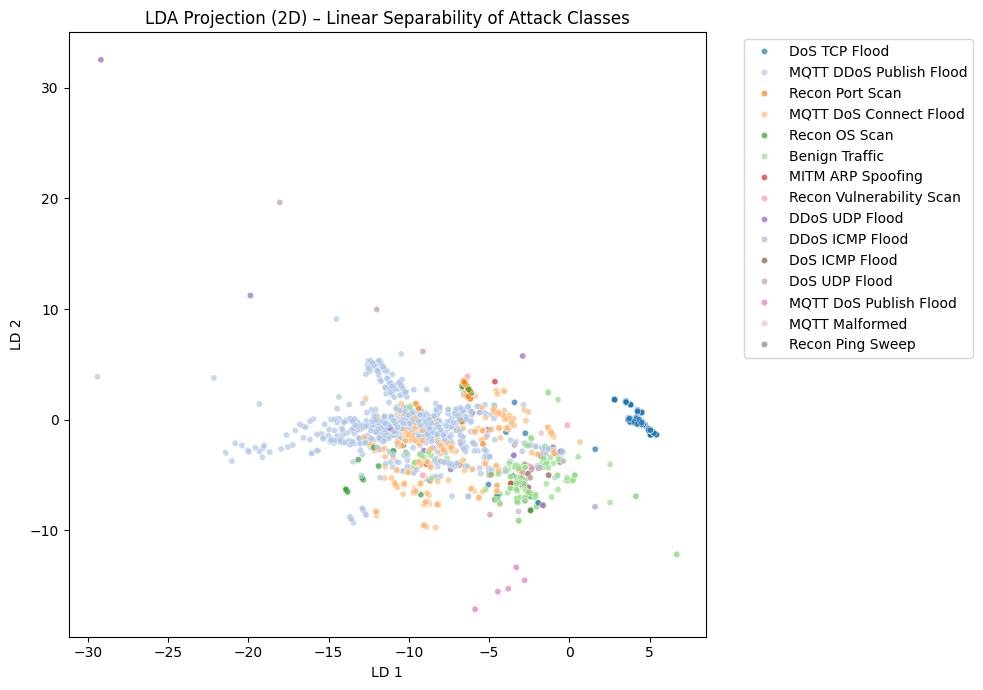

Running t-SNE...


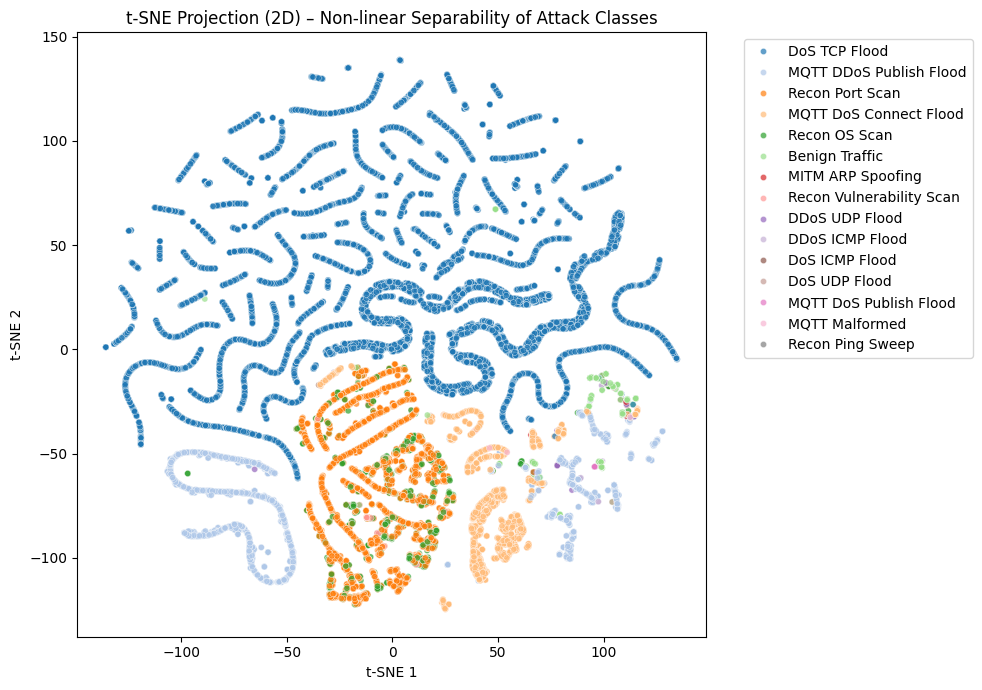

In [17]:
X = df.drop(columns=["Attack Name", "Label", "Dst IP"], errors="ignore")
y = df["Attack Name"]

# For visualization, we will sample a subset of the data to reduce computation time
sample_size = 30000

df_sample = df.sample(sample_size, random_state=42)
X_sample = df_sample.drop(columns=["Attack Name", "Label", "Dst IP"], errors="ignore")
y_sample = df_sample["Attack Name"]
 
# Scaling the sampled data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# LDA Projection (Linear Separability)

print("Fitting Linear Discriminant Analysis...")

lda = LDA(n_components=2)
X_lda = lda.fit_transform(X_scaled, y_sample)

plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_lda[:,0], y=X_lda[:,1],
    hue=y_sample,
    palette="tab20",
    s=20, alpha=0.7
)
plt.title("LDA Projection (2D) – Linear Separability of Attack Classes")
plt.xlabel("LD 1")
plt.ylabel("LD 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# t-SNE Projection (Non-linear Separability)

print("Running t-SNE...")

tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1500,
    random_state=42,
    init="pca"
)

X_tsne = tsne.fit_transform(X_scaled)


plt.figure(figsize=(10,7))
sns.scatterplot(
    x=X_tsne[:,0], y=X_tsne[:,1],
    hue=y_sample,
    palette="tab20",
    s=20, alpha=0.7
)
plt.title("t-SNE Projection (2D) – Non-linear Separability of Attack Classes")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


The dimensionality-reduction analysis demonstrates that the selected features enable strong non-linear separation between attack classes, while purely linear boundaries fail to capture the underlying patterns. This confirms both the quality of the feature engineering process and the necessity of using non-linear machine-learning algorithms in the modeling stage.

# Export Data to GOLD

In [15]:
df_scaled.to_csv("../data/gold/dataset_gold.csv", index=False)
print("GOLD dataset exported successfully to '../data/gold/dataset_gold.csv'")

GOLD dataset exported successfully to '../data/gold/dataset_gold.csv'


# Export labels encoder to map models prediction

In [8]:
encoder_path = "../models/label_encoder_attack_name.pkl"

with open(encoder_path, "wb") as f:
    pickle.dump(le, f)

print(f"LabelEncoder for attack_name exported correctly to: {encoder_path}")

encoder_path = "../models/label_encoder_dst_ip.pkl"

with open(encoder_path, "wb") as f:
    pickle.dump(le_ip, f)

print(f"LabelEncoder for dst_ip exported correctly to: {encoder_path}")

LabelEncoder for attack_name exported correctly to: ../models/label_encoder_attack_name.pkl
LabelEncoder for dst_ip exported correctly to: ../models/label_encoder_dst_ip.pkl


# Summary of this stage

All transformations required for modeling have now been completed.  
Throughout this notebook, we removed irrelevant and non-discriminative features, eliminated multicollinearity, standardized numerical variables, encoded attack labels, and validated feature usefulness through LDA and t-SNE visualizations.

The resulting DataFrame already represents the fully preprocessed GOLD dataset.  
on modeling, we simply define from GOLD:

- **X**: the final feature set  
- **y**: the encoded attack labels  

Finally, the complete dataset is exported to the **Gold layer**, ready for training and evaluation in the next stage of the project.
